#Bigram Lookup

Script to look up pointwise mutual information values calculated for the bigrams in my dissertation experiment stimuli. This is for Chapter 3 of my dissertation, analyzing association strength within and across IU and clause boundaries. 

The pointwise MI values were calcultated for all bigrams in the Santa Barbara Corpus and saved as SBC-bigrams.txt 

The bigrams in my stimuli are contained in WordPairsScores.csv

In [211]:
import pandas as pd
from nltk import WordNetLemmatizer
import numpy as np
import re

##Opening Word Pairs

In [212]:
WordPairs = pd.read_csv("/Users/heathersimpson/Documents/Dissertation/Articles/Chp3_IUvsClauseBoundaries/WordPairsScores_withPOS.csv", sep="\t", index_col=None)
WordPairs.columns

Index([u'CLCount', u'IUCount', u'IUStatus', u'MatchStatus', u'StimID',
       u'Subject', u'WCount', u'Word', u'WordPosition', u'Matching',
       u'WithinIU', u'ClauseBoundary', u'Boundary', u'BoundaryType', u'POS'],
      dtype='object')

In [213]:
WordPairs['Word'][:10]

0          Then-when
1          when-when
2             when-a
3           a-person
4       person-fills
5          fills-out
6             out-or
7             or-has
8          has-other
9    other-employees
Name: Word, dtype: object

##Opening SBC-bigrams

In [214]:
bigrams = pd.read_csv("SBC-bigrams.txt", sep="\t")

Make sure it looks right

In [215]:
bigrams.head()

,Word1,Word2,pwMI
0,let's,break,3.078091
1,she'll,cut,5.727598
2,an,antique,5.382757
3,account,who,3.001011
4,very,top,2.329182


I'll join the Word1 and Word2 strings with a dash so they will be efficiently matched as a single string

In [216]:
bigrams['Word1and2']= map(lambda x,y: x+"-"+y, bigrams['Word1'], bigrams['Word2'])

In [217]:
bigrams['Word1and2'][:10]

0     let's-break
1      she'll-cut
2      an-antique
3     account-who
4        very-top
5        minus-ex
6     free-ticket
7     shit-really
8    be-beautiful
9      visit-with
Name: Word1and2, dtype: object

##Lemmatize WordPairs
We need to run the WordNet Lemmatizer on the nouns and verbs in the stimulus word pairs, so that we can accurately match them to the lemmatized SBC bigrams, and lower the strings.

We need their POS tags from WordPairs (extracted in GetPOSTagsforWordPairs.ipynb)


In [218]:
wnl = WordNetLemmatizer()

In [219]:
def getlemWordPairs(words, pos):
    newwords = []
    count = 0
    for w in words:
        eachw = w.split("-")
        eachpos = pos[count].split("-")
        if len(eachpos)==3: # accounts for contractions like "wasn't" that were split by parser
            eachpos.pop(1)
        for i in range(len(eachw)):
            eachw[i] = eachw[i].lower()
            if eachpos[i][0]== "N":
                eachw[i] = wnl.lemmatize(eachw[i],"n")
            elif eachpos[i][0] == "V":
                eachw[i]= wnl.lemmatize(eachw[i],"v")
        pair = "-".join(eachw)
        newwords.append(pair)
        count+=1
    return newwords   

run function to lemmatize WordPairs

In [220]:
lemWordPairs = getlemWordPairs(WordPairs['Word'], WordPairs['POS'])

In [221]:
lemWordPairs[:10]

['then-when',
 'when-when',
 'when-a',
 'a-person',
 u'person-fill',
 u'fill-out',
 'out-or',
 u'or-have',
 u'have-other',
 u'other-employee']

In [222]:
WordPairs['lemWordPairs'] = lemWordPairs

In [223]:
WordPairs[:5]

,CLCount,IUCount,IUStatus,MatchStatus,StimID,Subject,WCount,Word,WordPosition,Matching,WithinIU,ClauseBoundary,Boundary,BoundaryType,POS,lemWordPairs
0,10,14,acrossIU,bothforgotten,0,0,71,Then-when,0.007042,1,0,0,1,IU,RB-WRB,then-when
1,10,14,withinIU,bothforgotten,0,0,71,when-when,0.021127,1,1,0,0,None,WRB-WRB,when-when
2,10,14,withinIU,bothforgotten,0,0,71,when-a,0.035211,1,1,1,1,Clause,WRB-DT,when-a
3,10,14,withinIU,bothforgotten,0,0,71,a-person,0.049296,1,1,0,0,None,DT-NN,a-person
4,10,14,withinIU,bothforgotten,0,0,71,person-fills,0.063380,1,1,0,0,None,NN-VBZ,person-fill


##Look up pointwise MI in SBC-bigrams


###First let's get a subset of WordPairs for one Subject
The same Word pairs are repeated for all subjects in the dataset WordPairs, so if we do the lookup on this list it will be unnecessarily large

In [224]:
bysubj = WordPairs.groupby('Subject')

In [225]:
subj0 = bysubj.get_group(0)
pairs_words = subj0['lemWordPairs'].values
pos = subj0['POS'].values

In [226]:
mi = bigrams['pwMI'][bigrams['Word1and2']=='then-when'].values

In [227]:
float(mi[0])

1.56904680453

In [229]:
pointwiseMI = []
for p in pairs_words:
    MI = bigrams['pwMI'][bigrams['Word1and2']==p].values
    if len(MI)>0:
        pointwiseMI.append(float(MI[0]))
    else:
        pointwiseMI.append(0)

In [230]:
len(pointwiseMI)

1964

In [231]:
pointwiseMI[0:5]

[1.56904680453,
 1.55277197863,
 -0.900085678179,
 2.3944431431599997,
 4.05753539495]

Check out results

In [232]:
pointwiseMI.index(max(pointwiseMI))

614

In [233]:
pairs_words[614]

'terrazzo-flooring'

This makes sense because both of these words probably appear only once, with each other... shows we should norm against frequency? Or include frequency in the regression? Or use a larger corpus? or a diff measure?

##Add pointwise MI to WordPairs csv

First need to multiply pointwiseMI by number of subjects so it's same length as WordPairs

In [234]:
len(pointwiseMI*101)

198364

In [235]:
len(WordPairs)

198364

In [236]:
#pointwiseMI = list(pointwiseMI)
#pointwiseMI[pointwiseMI==None]

In [237]:
count = 0
no_match_inSBCbigrams = []
for m in pointwiseMI:
    if m == 0:        
        print pairs_words[count] + " " + pos[count] + " at position " + str(count)
        no_match_inSBCbigrams.append(count)
    count+=1

home-patch RB-VBD at position 253
patch-us VBD-PRP at position 254
so-crippling NN-JJ at position 337
service-debt VBN-NN at position 382
step-buck NNS-VBD at position 439
buck-kick VBD-VBD at position 440
and-polish CC-VBN at position 611
polish-this VBN-DT at position 612
between-build IN-VBG at position 1198
of-enlighten IN-VBG at position 1385
enlighten-his VBG-PRP$ at position 1386
and-rearended CC-VBD at position 1438
rearended-em VBD-NN at position 1439
of-decompose IN-VBG at position 1547
decompose-or VBG-CC at position 1548
ninety-sixes VBZ-VBZ at position 1637
sixes-i VBZ-PRP at position 1638
of-bite IN-VBD at position 1838
phone-hmm NN-JJ at position 1941
hmm-be JJ-VBZ at position 1942
other-incidences JJ-JJ at position 1956
incidences-where JJ-WRB at position 1957


In [238]:
len(no_match_inSBCbigrams)

22

### Look up non-lemmatized version of non-matched pairs in non-lemmatized version of corpus

Load in non-lemmatized bigrams

In [239]:
nonlembigrams = pd.read_csv("SBC-nonlembigrams.txt", sep="\t")
nonlembigrams['Word1and2']= map(lambda x,y: x+"-"+y, nonlembigrams['Word1'], nonlembigrams['Word2'])

In [ ]:
nonlembigrams.head()

Look up using lowered version of WordPairs['Word']

In [ ]:
nonlem_pairwords = [w.lower() for w in WordPairs['Word'].values]
nonlem_pairwords[:10]

In [243]:
nonlempointwiseMI = []
for p in pairs_words:
    MI = nonlembigrams['pwMI'][nonlembigrams['Word1and2']==p].values
    if len(MI)>0:
        nonlempointwiseMI.append(float(MI[0]))
    else:
        nonlempointwiseMI.append(0)

In [244]:
len(nonlempointwiseMI)

1964

###Replace MI = 0 values with non-lem MI values

In [ ]:
for p in no_match_inSBCbigrams:
    print "replacing 0 with " + str(nonlempointwiseMI[p])
    pointwiseMI[p] = nonlempointwiseMI[p]

In [259]:
len([m for m in pointwiseMI if m==0])

18

In [ ]:
len(pointwiseMI)

In [246]:
WordPairs['pwMI']=  pointwiseMI*101

In [247]:
WordPairs[:5]

,CLCount,IUCount,IUStatus,MatchStatus,StimID,Subject,WCount,Word,WordPosition,Matching,WithinIU,ClauseBoundary,Boundary,BoundaryType,POS,lemWordPairs,pwMI
0,10,14,acrossIU,bothforgotten,0,0,71,Then-when,0.007042,1,0,0,1,IU,RB-WRB,then-when,1.569047
1,10,14,withinIU,bothforgotten,0,0,71,when-when,0.021127,1,1,0,0,None,WRB-WRB,when-when,1.552772
2,10,14,withinIU,bothforgotten,0,0,71,when-a,0.035211,1,1,1,1,Clause,WRB-DT,when-a,-0.900086
3,10,14,withinIU,bothforgotten,0,0,71,a-person,0.049296,1,1,0,0,None,DT-NN,a-person,2.394443
4,10,14,withinIU,bothforgotten,0,0,71,person-fills,0.063380,1,1,0,0,None,NN-VBZ,person-fill,4.057535


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
%matplotlib inline

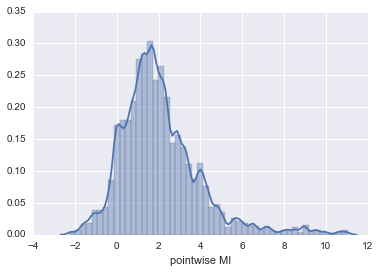

In [251]:
sns.distplot(WordPairs['pwMI'], axlabel="pointwise MI")

In [41]:
print len(word12)
print len(pwMI)

89183
89183


In [252]:
pd.DataFrame.to_csv(WordPairs, path_or_buf="../WordPairsScores_withPOS_MI.csv", sep='\t', index=False, columns=WordPairs.columns)

In [253]:
sum(WordPairs['pwMI']==0)

1818